## Notebook to compare ARO and TRO based data (test data) for different values of $\rho$, generates Fig. 10 and Fig. 12 of manuscript

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from iwc2tb.GMI.gmiData_test import gmiData
import os
from matplotlib import cm
import matplotlib.colors as colors
from iwc2tb.common.hist2d import hist2d
import pandas as pd
plt.rcParams.update({'font.size': 20})

In [2]:
quantiles         = np.linspace(0.01, 0.99, 50)
imedian            = np.argwhere((quantiles >= 0.49) & (quantiles < 0.51))[0][0]

In [3]:
AY      = []
AY_pre  = []
AY_mean = []
PR      = []
for i in ["0"]:
    
    filename_aro = "qrnn_gmi_nn_lpa_v" + i + "_jan.pickle"

    with open(filename_aro, "rb") as f:   
        ay      = pickle.load(f)
        ay_pre  = pickle.load(f)
        ay_mean = pickle.load(f)
        pr      = pickle.load(f)
        ay_s     = pickle.load(f)

        f.close()
        
    AY.append(ay)
    AY_pre.append(ay_pre.reshape(-1, 1, 50))
    AY_mean.append(ay_mean.reshape(-1, 1))
    PR.append(pr)

AY      = np.concatenate(AY, axis = 1)
AY_pre  = np.concatenate(AY_pre, axis = 1)
AY_mean = np.concatenate(AY_mean, axis = 1)
PR      = np.concatenate(PR, axis = 1)
    
    
    

In [4]:
AY_pre.shape

(1681625, 1, 50)

In [5]:
TY      = []
TY_pre  = []
TY_mean = []

for i in ["0"]:
    
    filename_aro = "qrnn_gmi_nn_lpa_pr1_v" + i + "_jan.pickle" 

    with open(filename_aro, "rb") as f:   
        ty      = pickle.load(f)
        ty_pre  = pickle.load(f)
        ty_mean = pickle.load(f)
        pr      = pickle.load(f)
        t_s     = pickle.load(f)

        f.close()
        
    TY.append(ty)
    TY_pre.append(ty_pre.reshape(-1, 1, 50))
    TY_mean.append(ty_mean.reshape(-1, 1))


TY      = np.concatenate(TY, axis = 1)
TY_pre  = np.concatenate(TY_pre, axis = 1)
TY_mean = np.concatenate(TY_mean, axis = 1)

In [6]:
AY.shape

(1681625, 1)

In [7]:
batchSize          = 256
inputs             = np.array( ["ta", "t2m",  "wvp", "z0", "lat",  "stype"])
outputs            = "iwp"
xlog               = True
latlims            = [0, 45]
latlims            = [0, 65]
test_data          = gmiData(os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/TB_GMI_val_jan2010_withnoise.nc"), 
                             inputs,
                             outputs,
                             batch_size = batchSize,
                             latlims = latlims,
                             normalise = None)
                             #log_iwp = xlog)


{0: (269.1045265852, 20.644280809888876), 1: (265.5805531796191, 23.67496565196527), 2: (266.14922500272576, 14.274354445310214), 3: (257.70678569647896, 10.02145155186574), 4: (286.61770363132, 14.281002757198248), 5: (23.0027955926007, 16.823302635276093), 6: (169.73314260732718, 512.1075619128192), 7: (-1.5001814941685525, 37.62187709361819)}


In [8]:
z0 = test_data.z0
wvp = test_data.wvp

In [9]:
tb  = test_data.x[:, :4]
lat = test_data.lat
lat = np.repeat(lat, AY.shape[1], axis = 1)


In [10]:
stype = test_data.stype
stype = np.argmax(stype, axis = 1)
stype = np.squeeze(stype)
stype

array([0, 0, 0, ..., 1, 1, 1])

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Log scale: values of z <= 0 have been masked


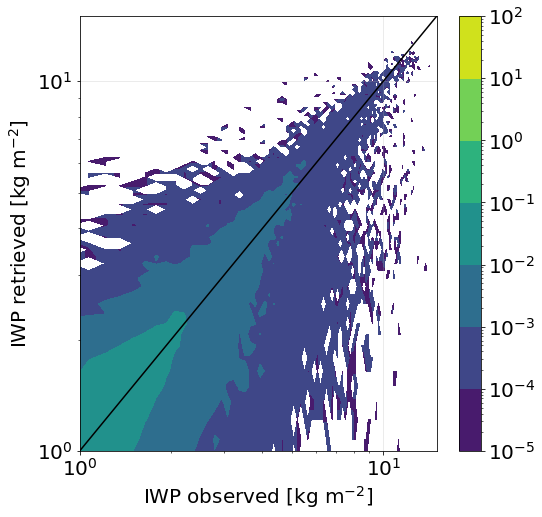

In [11]:
import scipy
from matplotlib import ticker, cm
xyrange = [[1e-4, 15], [1e-4, 15]] # data range
bins = [105, 105] # number of bins
#iwpbins = np.array([0.0,.0001,.00025,.0005,0.001,.0025,.005,.01,.025,.05,.1,
#                 .25,.5,1,2, 5,7,8, 9,10,12,13, 14, 15, 16, 17, 18, 19, 20, 22, 25])

fig, axes = plt.subplots(1, 1, figsize = [8, 8])
for ax, a, a0 in zip([axes], 
                     [ AY_mean.ravel()], 
                     [AY.ravel()]):

   
    hh, locx, locy = np.histogram2d(a0, a, 
                                    range=xyrange, 
                                    bins=bins, density = True)

    posx = np.digitize(a0, locx)
    posy = np.digitize(a, locy)
    cs = ax.contourf(np.flipud(hh.T),
                    extent=np.array(xyrange).flatten(), 
                locator= ticker.LogLocator(), origin='upper')
    cbar = fig.colorbar(cs)
    #ax.set_ylim([0, 12])
    #ax.set_xlim([0, 12])
    xy = np.arange(0, 20, 1)
    yy = xy
    ax.plot(xy, yy, 'k')
    ax.set_ylabel(r"IWP retrieved [kg m$^{-2}$]")
    ax.set_xlabel(r"IWP observed [kg m$^{-2}$]")
    ax.set_xlim([1, 15])
    ax.set_ylim([1, 15])
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid("on", alpha = 0.3)
fig.savefig("scatter_IWP_test_data.pdf", bbox_inches = "tight")


In [59]:
def zonal_mean(lat, iwp, latbins):

    bins     = np.digitize(lat, latbins)
    
    nbins    = np.bincount(bins)
    iwp_mean = np.bincount(bins, iwp)

    return iwp_mean, nbins


In [13]:
def mfe( y0, y):
    return np.median(10**(np.abs(np.log10(y/y0))) - 1) * 100

def calculate_mfe(y0, y):
    nbins = 60
    logbins = np.log10(np.logspace(np.log10(1e-4), np.log10(13), nbins))
    ibins = np.digitize(np.log10(y0), logbins)
    err = []
    for ix in range(nbins):

        ix = np.where(ibins == ix)[0]

        err.append(mfe(y0[ix], y[ix]))
    return err, logbins

In [14]:
quantiles

array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
       0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
       0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
       0.89, 0.91, 0.93, 0.95, 0.97, 0.99])

In [15]:
iwplim = 0.001 #[kg/m2]

def false_hits(y1, y_pos_mean1, iwplim):
    falsehits = y_pos_mean1[y1 <= iwplim] >= iwplim

    falsemiss = y_pos_mean1[y1 >= iwplim] <= iwplim

    print("falsemiss among total data : ", np.sum(falsemiss)/y1.shape[0], "\n",
          "falsehits among total data : ", np.sum(falsehits)/y1.shape[0])


    print("falsemiss among IWP < 0.01 kg/m2 : ", np.sum(falsemiss)/np.sum(y1[y_pos_mean1 <= iwplim]), "\n",
          "falsehits among IWP < 0.01 kg/m2 : ", np.sum(falsehits)/np.sum(y_pos_mean1[y1 <= iwplim]))



In [16]:
false_hits(AY, AY_mean, iwplim = 0.03)

falsemiss among total data :  0.03508986843083327 
 falsehits among total data :  0.0447192447781164
falsemiss among IWP < 0.01 kg/m2 :  9.2921318465416 
 falsehits among IWP < 0.01 kg/m2 :  7.857557541541907


In [66]:
def plot_iwp(AY_mean, AY, TY_mean, TY, lat):
    latbins = np.arange(-60, 62, 2)
    
    iargs = np.random.randint(0, AY_mean.size, int(10 * AY_mean.size/100))
    
    zay, zayc      = zonal_mean(lat, AY_mean, latbins)
    zty, ztyc      = zonal_mean(lat, TY_mean, latbins)
    zy, zyc        = zonal_mean(lat, AY, latbins)
    
    N = 500
    zay_bs = np.zeros([N, zay.size])
    zayc_bs = np.zeros([N, zayc.size])
    zty_bs = np.zeros([N, zay.size])
    ztyc_bs = np.zeros([N, zayc.size])
    zy_bs = np.zeros([N, zay.size])
    zyc_bs = np.zeros([N, zayc.size])
    for j in range(N):
        iargs = np.random.randint(0, AY_mean.size, int(AY_mean.size*0.1))
        zay_bs[j, :], zayc_bs[j, :] = zonal_mean(lat[iargs], AY_mean[iargs], latbins)
        zty_bs[j, :], ztyc_bs[j, :] = zonal_mean(lat[iargs], TY_mean[iargs], latbins)
        zy_bs[j, :], zyc_bs[j, :] = zonal_mean(lat[iargs], AY[iargs], latbins)
    


    std_a = np.std(zay_bs/zayc_bs, axis = 0)
    std_t = np.std(zty_bs/ztyc_bs, axis = 0)
    std_r = np.std(zy_bs/zyc_bs, axis = 0)

    fig, ax = plt.subplots(1, 1, figsize = [8, 8])
    ax.plot(zty[:-1]/ztyc[:-1],latbins, c = "tab:blue", linestyle = "-",  linewidth = 2.,  label = "LPA-TRO") 
    ax.plot(zay[:-1]/zayc[:-1],latbins, c = "tab:red", linestyle = "-", linewidth = 2.,  label = "LPA-aARO") 
    ax.plot(zy[:-1]/zyc[:-1],latbins, c = "black", linestyle = "--", linewidth = 1.5,  label = "Reference") 
    
    ax.fill_betweenx(latbins, zty[:-1]/ztyc[:-1] - std_t[:-1] ,zty[:-1]/ztyc[:-1] + std_t[:-1], color = "tab:blue",alpha = 0.2) 
    ax.fill_betweenx(latbins, zay[:-1]/zayc[:-1] - std_a[:-1], zay[:-1]/zayc[:-1] + std_a[:-1], color = "tab:red", alpha = 0.2)
    ax.fill_betweenx(latbins, zy[:-1]/zyc[:-1] - std_r[:-1], zy[:-1]/zyc[:-1] + std_r[:-1], color = "black", alpha = 0.2) 
    #ax.plot(zay[:-1]/zayc[:-1],latbins, c = "tab:blue", linestyle = "--", linewidth = 2.,  label = "LPA-aARO") 
    #ax.plot(zy[:-1]/zyc[:-1],latbins, c = "tab:red", linewidth = 2.,  label = "Reference") 
    
    ax.set_ylabel("Latitude [deg]")
    ax.set_xlabel(r"IWP [kg m$^{-2}$]")
    ax.legend(fontsize = 16)
    ax.grid(alpha = 0.3)
    #ax.set_xlim([-0.3, 0.3])
    fig.savefig("zonal_mean_all_jan_testdata.pdf", bbox_inches = "tight")



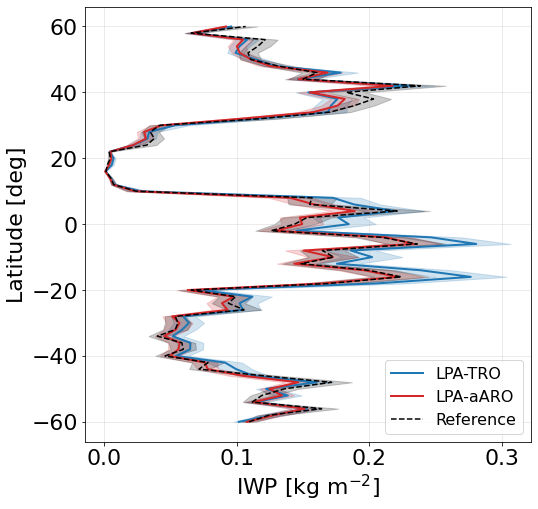

In [67]:
plot_iwp(AY_mean.ravel(), AY.ravel(), TY_mean.ravel(), TY.ravel(), lat.ravel())

In [19]:
AY = AY.ravel()
TY = TY.ravel()
AY_mean = AY_mean.ravel()
TY_mean = TY_mean.ravel()

stype = stype.ravel()

In [20]:
def plot_scatter_mask(lsmmask, figname):
    fig, ax = plt.subplots(1, 2, figsize = [15, 6])
    ax = ax.ravel()

    x = np.arange(0.0001, 15, 1)
    y = x

    ax[1].scatter(ty[lsmmask], ty_mean[lsmmask], c = pr[lsmmask],
                  vmin = 1.2, vmax = 1.4, alpha = 0.5, label = "subset", cmap = cm.Blues)
    cs = ax[0].scatter(ay[lsmmask], ay_mean[lsmmask], c = pr[lsmmask], 
                       vmin = 1.2, vmax = 1.4, alpha = 0.5, label = "subset", cmap = cm.Blues)
    fig.colorbar(cs, ax = ax)
    ax[0].plot(x, y, "k")
    ax[1].plot(x, y, "k")
    ax[0].set_title("ARO based training")
    ax[1].set_title("TRO based training")
    ax[0].set_xlabel(r"IWP0 [kg m$^{-2}$]")
    ax[0].set_ylabel(r"IWP_mean [kg m$^{-2}$]")

    ax[1].set_xlabel(r"IWP0 [kg m$^{-2}$]")
    ax[1].set_ylabel(r"IWP_mean [kg m$^{-2}$]")
    #ax[0].legend()
    #ax[1].legend()
    ax[0].set_xlim([1e-4, 20])
    ax[1].set_xlim([1e-4, 20])
    ax[0].set_ylim([1e-4, 20])
    ax[1].set_ylim([1e-4, 20])

    #ax[1].set_yscale("log")
    #ax[1].set_xscale("log")
    #ax[0].set_yscale("log")
    #ax[0].set_xscale("log")
    fig.savefig(figname, bbox_inches = "tight", dpi = 300)

In [21]:
def bias(y, y0):
    return np.mean(y-y0)

def mae(y, y0):
    return np.mean(np.abs(y-y0))

def rmsd(y, y0):
    return np.sqrt(np.mean((y-y0)**2))
    



In [22]:
def stats(y, y0):
    
    bias = np.mean(y-y0)
    mae  = np.mean(np.abs(y-y0))
    rms  = np.sqrt(np.mean((y-y0)**2))
    
    return bias, mae, rms

In [23]:
PR = PR.ravel()
TY = TY.ravel()


In [24]:
statistics_aro = np.zeros([9, 3])
statistics_tro = np.zeros([9, 3])

# all data
statistics_aro[0, :] = stats(AY_mean, AY)
statistics_tro[0, :] = stats(TY_mean, TY)

# PR < 1.15
amask = (PR <= 1.15) & (stype == 0)
statistics_aro[1, :] = stats(AY_mean[amask], AY[amask])
statistics_tro[1, :] = stats(TY_mean[amask], TY[amask])

amask = (PR > 1.15) & (PR <= 1.25) & (stype == 0)
statistics_aro[2, :] = stats(AY_mean[amask], AY[amask])
statistics_tro[2, :] = stats(TY_mean[amask], TY[amask])

amask = (PR > 1.25) & (stype == 0)
statistics_aro[3, :] = stats(AY_mean[amask], AY[amask])
statistics_tro[3, :] = stats(TY_mean[amask], TY[amask])


# water
amask = stype == 0
statistics_aro[4, :] = stats(AY_mean[amask], AY[amask])
statistics_tro[4, :] = stats(TY_mean[amask], TY[amask])

# land
amask = stype == 1
statistics_aro[5, :] = stats(AY_mean[amask], AY[amask])
statistics_tro[5, :] = stats(TY_mean[amask], TY[amask])

# snow/seaice
amask = (stype == 2) 
statistics_aro[6, :] = stats(AY_mean[amask], AY[amask])
statistics_tro[6, :] = stats(TY_mean[amask], TY[amask])


# water + PR > 1.25
amask = stype == 0
amask1 = PR > 1.3
amask = np.logical_and(amask, amask1)
statistics_aro[7, :] = stats(AY_mean[amask], AY[amask])
statistics_tro[7, :] = stats(TY_mean[amask], TY[amask])

# land + PR > 1.25
amask = stype == 1
amask1 = PR > 1.3
amask = np.logical_and(amask, amask1)
statistics_aro[8, :] = stats(AY_mean[amask], AY[amask])
statistics_tro[8, :] = stats(TY_mean[amask], TY[amask])

statistics_aro = np.round(statistics_aro, decimals = 3)
statistics_tro = np.round(statistics_tro, decimals = 3)

In [76]:
prbins   = np.arange(1, 1.41, 0.03)
bias_a_bs = np.zeros([500, prbins.size-1])
bias_t_bs = np.zeros([500, prbins.size-1])
mae_a_bs = np.zeros([500, prbins.size-1])
mae_t_bs = np.zeros([500, prbins.size-1])
rmsd_a_bs = np.zeros([500, prbins.size-1])
rmsd_t_bs = np.zeros([500, prbins.size-1])
for j in range(500):
    iargs = np.random.randint(0, AY_mean.size, int(AY_mean.size*0.1))
    AY_mean_bs = AY_mean[iargs]
    TY_mean_bs = TY_mean[iargs]
    AY_bs = AY[iargs]
    TY_bs = TY[iargs]
    PR_bs = PR[iargs]

    ipr   = np.digitize(PR_bs, prbins)
    npr   = np.zeros([prbins.size])
    for i in range(1, prbins.size):
        amask = ipr == i
        bias_a_bs[j, i-1], mae_a_bs[j, i-1], rmsd_a_bs[j, i-1] = stats(AY_mean_bs[amask], AY_bs[amask])
        bias_t_bs[j, i-1], mae_t_bs[j, i-1], rmsd_t_bs[j, i-1] = stats(AY_mean_bs[amask], AY_bs[amask])
std_a_b = np.std(bias_a_bs, axis = 0)
std_t_b = np.std(bias_t_bs, axis = 0)
std_a_m = np.std(mae_a_bs, axis = 0)
std_t_m = np.std(mae_t_bs, axis = 0)
std_a_r = np.std(rmsd_a_bs, axis = 0)
std_t_r = np.std(rmsd_t_bs, axis = 0)

In [95]:
def plot_stats(amask1, fig, ax, c, offset, labels, figname = "statistics.png"):

    prbins   = np.arange(1, 1.41, 0.03)
    prcenter = (prbins[1:] + prbins[:-1]) * 0.5
    
    statistics_aro = np.zeros([prbins.size - 1, 3])
    statistics_tro = np.zeros([prbins.size - 1, 3])
    npr            = np.zeros([prbins.size - 1])



    ipr   = np.digitize(PR, prbins)
    npr   = np.zeros([prbins.size])

    for i in range(1, prbins.size):
        amask = ipr == i
        amask = np.logical_and(amask, amask1)
        statistics_aro[i-1, :] = stats(AY_mean[amask], AY[amask])
        statistics_tro[i-1, :] = stats(TY_mean[amask], TY[amask])
        npr[i-1]               = np.sum(amask)

        
    DF_tro = pd.DataFrame(statistics_tro, columns = ["Bias", "MAE", "RMSD"], 
                      index = prcenter)
    DF_aro = pd.DataFrame(statistics_aro, columns = ["Bias", "MAE", "RMSD"], 
                      index = prcenter)

    
    ax = ax.ravel()

    for i, key in enumerate(["Bias", "MAE", "RMSD" ]):

        ax[i].plot(prcenter, DF_tro[key], "-o", color = "tab:blue", label = labels[0], linewidth = 2.5)
        #ax[i].fill_between(prcenter, DF_tro[key] - DF_tro["SD1"], DF_tro[key] + DF_tro["SD1"], alpha = 0.2)
        ax[i].plot(prcenter, DF_aro[key], "-o", color = "tab:red", label = labels[1], linewidth = 2.5)
        #ax[i].fill_between(prcenter, DF_aro[key] - DF_aro["SD1"], DF_aro[key] + DF_aro["SD1"], alpha = 0.2)
        
        ax[i].set_ylabel(key + r" [kg m$^{-2}$]")
        ax[i].grid("on", alpha = 0.3)
        ax[i].set_xlabel("polarisation ratio")
        plt.tight_layout(pad = 0.5)


    ax[0].fill_between(prcenter, DF_tro["Bias"] - std_t_b, DF_tro["Bias"] + std_t_b, color = "tab:blue", alpha = 0.2)
    ax[0].fill_between(prcenter, DF_aro["Bias"] - std_a_b, DF_aro["Bias"] + std_a_b, color = "tab:red", alpha = 0.2)

    ax[1].fill_between(prcenter, DF_tro["MAE"] - std_t_m, DF_tro["MAE"] + std_t_m, color = "tab:blue", alpha = 0.2)
    ax[1].fill_between(prcenter, DF_aro["MAE"] - std_a_m, DF_aro["MAE"] + std_a_m, color = "tab:red", alpha = 0.2)
  
    ax[2].fill_between(prcenter, DF_tro["RMSD"] - std_t_r, DF_tro["RMSD"] + std_t_r, color = "tab:blue", alpha = 0.2)
    ax[2].fill_between(prcenter, DF_aro["RMSD"] - std_a_r, DF_aro["RMSD"] + std_a_r, color = "tab:red", alpha = 0.2)
  

In [96]:
DF_tro["RMSD"] 

1.015    0.171766
1.045    0.300444
1.075    0.171528
1.105    0.266715
1.135    0.278529
1.165    0.179773
1.195    0.248229
1.225    0.325835
1.255    0.265717
1.285    0.296751
1.315    0.327647
1.345    0.235535
1.375    0.350465
Name: RMSD, dtype: float64

In [97]:
def three_sigma(tb):
    """
    three sigma rule to classify cloudy and clear-sky tb
    

    Parameters
    ----------
    tb : 183+-3 GHz 

    Returns
    -------
    mask : scalar, the threshold value
    """
    bins = np.arange(100, 310, 1)
    hist = np.histogram(tb, bins, density = True)


    mids = 0.5*(bins[1:] + bins[:-1])

    tbmean = np.sum(hist[0] * mids)

    sd  = np.sqrt(np.sum(hist[0] * (mids - tbmean)**2))

    tbmax = mids[np.argmax(hist[0])]
    
    mask = tbmax-3*sd

    return mask

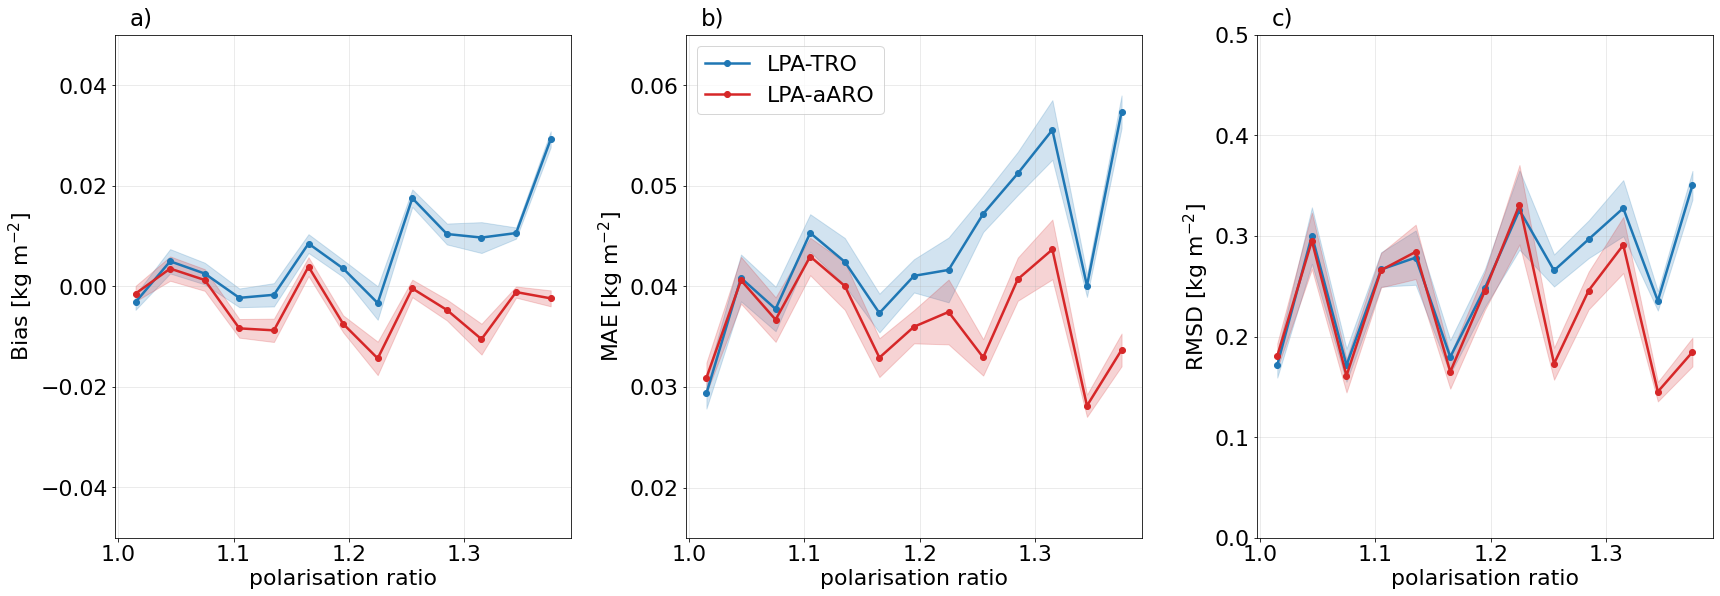

In [99]:
plt.rcParams.update({'font.size': 22})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#amask1 = (stype >=0) & (lat.ravel()> -30.0) & (lat.ravel() <= 0.0)
amask1 = stype >=0
fig, ax = plt.subplots(1,3, figsize = [24, 8])
ax = ax.ravel()
#amask1 = np.repeat(amask1.reshape(-1, 1), 4, axis = 1)
#plot_stats(amask1, fig, ax, c = colors[1], labels = ["LPA-TRO", "LPA-aARO"], offset = -0.01)
labels =  ["LPA-TRO", "LPA-aARO"]
prbins   = np.arange(1, 1.41, 0.03)
prcenter = (prbins[1:] + prbins[:-1]) * 0.5

statistics_aro = np.zeros([prbins.size - 1, 3])
statistics_tro = np.zeros([prbins.size - 1, 3])
npr            = np.zeros([prbins.size - 1])



ipr   = np.digitize(PR, prbins)
npr   = np.zeros([prbins.size])

for i in range(1, prbins.size):
    amask = ipr == i
    amask = np.logical_and(amask, amask1)
    statistics_aro[i-1, :] = stats(AY_mean[amask], AY[amask])
    statistics_tro[i-1, :] = stats(TY_mean[amask], TY[amask])
    npr[i-1]               = np.sum(amask)


DF_tro = pd.DataFrame(statistics_tro, columns = ["Bias", "MAE", "RMSD"], 
                  index = prcenter)
DF_aro = pd.DataFrame(statistics_aro, columns = ["Bias", "MAE", "RMSD"], 
                  index = prcenter)


ax = ax.ravel()

for i, key in enumerate(["Bias", "MAE", "RMSD" ]):

    ax[i].plot(prcenter, DF_tro[key], "-o", color = "tab:blue", label = labels[0], linewidth = 2.5)
    #ax[i].fill_between(prcenter, DF_tro[key] - DF_tro["SD1"], DF_tro[key] + DF_tro["SD1"], alpha = 0.2)
    ax[i].plot(prcenter, DF_aro[key], "-o", color = "tab:red", label = labels[1], linewidth = 2.5)
    #ax[i].fill_between(prcenter, DF_aro[key] - DF_aro["SD1"], DF_aro[key] + DF_aro["SD1"], alpha = 0.2)

    ax[i].set_ylabel(key + r" [kg m$^{-2}$]")
    ax[i].grid("on", alpha = 0.3)
    ax[i].set_xlabel("polarisation ratio")
    plt.tight_layout(pad = 0.5)
ax[1].legend()


ax[0].fill_between(prcenter, DF_tro["Bias"] - std_t_b, DF_tro["Bias"] + std_t_b, color = "tab:blue", alpha = 0.2)
ax[0].fill_between(prcenter, DF_aro["Bias"] - std_a_b, DF_aro["Bias"] + std_a_b, color = "tab:red", alpha = 0.2)

ax[1].fill_between(prcenter, DF_tro["MAE"] - std_t_m, DF_tro["MAE"] + std_t_m, color = "tab:blue", alpha = 0.2)
ax[1].fill_between(prcenter, DF_aro["MAE"] - std_a_m, DF_aro["MAE"] + std_a_m, color = "tab:red", alpha = 0.2)
  
ax[2].fill_between(prcenter, DF_tro["RMSD"] - std_t_r, DF_tro["RMSD"] + std_t_r, color = "tab:blue", alpha = 0.2)
ax[2].fill_between(prcenter, DF_aro["RMSD"] - std_a_r, DF_aro["RMSD"] + std_a_r, color = "tab:red", alpha = 0.2)
  


for i in range(3):
    ax[i].xaxis.grid(True, which='both')
    ax[i].yaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].yaxis.grid(True, which='both')
    
#ax[1].set_yscale("log")
#ax[2].set_yscale("log")
ax[0].set_ylim([-0.05, 0.05])
ax[1].set_ylim([0.015, 0.065])
ax[2].set_ylim([0, 0.5])
#ax[0].text(1., 0.052, s="a)", fontsize = 23)
#ax[1].text(1., 0.066, s="b)",  fontsize = 23)
#ax[2].text(1., 0.51, s="c)", fontsize = 23)

ax[0].text(1.01, 0.052, s="a)", fontsize = 23)
#ax[0].text(1.01, 0.425, s="a)", fontsize = 23)
#ax[0].text(1.01, 0.365, s="a)", fontsize = 23)
ax[1].text(1.01, 0.066, s="b)",  fontsize = 23)
ax[2].text(1.01, 0.51, s="c)", fontsize = 23)

fig.savefig("statistics_cloudyclear_LPA.pdf", bbox_inches = "tight")

In [ ]:
statistics_aro = np.zeros([prbins.size - 1, 3])
statistics_tro = np.zeros([prbins.size - 1, 3])
npr            = np.zeros([prbins.size - 1])

Y = np.repeat(AY.reshape(-1, 1), 10, axis = 1)
P = np.repeat(PR.reshape(-1, 1), 10, axis = 1)

ipr   = np.digitize(P, prbins)

amask1 = Y >= 0.5

for i in range(1, prbins.size):
    amask = ipr == i
    amask = np.logical_and(amask, amask1)
    statistics_aro[i-1, :] = stats(ay_s[amask], Y[amask])
    #statistics_tro[i-1, :] = stats(TY_mean[amask], TY[amask])
    npr[i-1]               = np.sum(amask)

DF_tro = pd.DataFrame(statistics_tro, columns = ["Bias", "MAE", "RMSD"], 
                  index = prcenter)
DF_aro = pd.DataFrame(statistics_aro, columns = ["Bias", "MAE", "RMSD"], 
                  index = prcenter)


In [ ]:
DF_aro

In [ ]:
def PDF_uncertainty_bins(y_pre, y0, ulim):
    dtb =(y_pre[:, imedian] - y0)
    uncertain = y_pre[:, -13] - y_pre[:, 12]

    
    im = uncertain <= ulim[0]
    print (np.sum(im), uncertain.max(), uncertain.min())
    bins = np.arange(-12.5, 15., 0.8)
    hist0 = np.histogram(dtb[im], bins, density = True)
    
    
    im = np.logical_and((uncertain < ulim[1]), ( uncertain >= ulim[0]) )
    hist1 = np.histogram(dtb[im], bins, density = True)
 
  
    im = uncertain >=ulim[1]
    hist2 = np.histogram(dtb[im], bins, density = True)
    
    
    return hist0[0], hist1[0],  hist2[0], bins

def count_true_events(y_pre, y0, ulim):
    
    dtb =(y_pre[:, 3] - y0)
    uncertain = y_pre[:, 5] - y_pre[:, 1]
 #I1V
    #ulim = [3, 4] #I2V
    #ulim = [1, 1.5 ]#I3V
    
    im = uncertain <= ulim[0]
    
    mask = np.logical_and(y0[im] >= y_pre[im, 1],  y0[im] <= y_pre[im, 5])
    icount1 = np.sum(mask)
    icount1 = icount1/np.sum(im) * 100
    
    
    im = np.logical_and((uncertain < ulim[1]), ( uncertain >= ulim[0]) )
    mask = np.logical_and(y0[im] >= y_pre[im, 1],  y0[im] <= y_pre[im, 5])
    icount2 = np.sum(mask)
    icount2 = icount2/np.sum(im) * 100
    
 
  
    im = uncertain >=ulim[1]
    mask = np.logical_and(y0[im] >= y_pre[im, 1],  y0[im] <= y_pre[im, 5])
    icount3 = np.sum(mask)
    icount3 = icount3/np.sum(im) * 100
    
    return np.round(icount1, 1), np.around(icount2, 1), np.round(icount3,1)
    

In [ ]:
def sharpness(y, mask = None):
    if mask is not None:
        s = np.mean((y[mask, -2] - y[mask, 1])/y[mask, imedian])
    else:
        s = np.mean((y[:, -2] - y[:, 1])/y[:, imedian])        
    return s

In [ ]:
sharpness(AY_pre, amask)

In [ ]:
sharpness(TY_pre, amask)

In [ ]:
def calibration(y_pre, y):
    n_intervals = len(quantiles)//2
    qs = quantiles
    total = 0.0
    intervals = np.array([q_r - q_l for (q_l, q_r) in zip(qs, reversed(qs))])[:n_intervals]
    counts = np.zeros(n_intervals)
    
    for i in range(n_intervals):
        l = y_pre[:, i]
        r = y_pre[:, -(i + 1)]
        counts[i] += np.logical_and(y >= l, y < r).sum()

    total += np.prod(y.size)

    return intervals[::-1], (counts / total)[::-1]


In [ ]:
amask = stype == 0
amask1 = np.abs(lat) <= 30.0

amask = np.logical_and(amask, amask1)

In [ ]:
def aic(y_pre, y, iupper, ilower, interval):
    upper      = y_pre[:, iupper]
    lower      = y_pre[:, ilower]
    alpha      = 1 - interval/100

    truevalues = y
    I1         = np.where(truevalues < lower, 1, 0)
    I2         = np.where(truevalues > upper, 1, 0)
    
    score      = (upper - lower) + 2/alpha * (lower - truevalues) * I1 + 2/alpha * (truevalues - upper) * I2
    
    return np.mean(score)


In [ ]:
amask = stype == 0
amask1 = np.abs(lat) <= 30.0

amask = np.logical_and(amask, amask1)

In [ ]:
ay_pre = AY_pre.reshape(-1, 50)
ty_pre = TY_pre.reshape(-1, 50)
ay     = AY.ravel()
ty     = TY.ravel()
mask   = amask.ravel()


In [ ]:
ascores = []
tscores = []
ascores_all = []
tscores_all = []
intervals = []
for i in range(25):
    ilower = i
    iupper = -1 - i
    interval = (quantiles[iupper] - quantiles[ilower]) * 100
    
    intervals.append(interval)
    
    ascores.append(aic(ay_pre[mask, :], ay[mask], iupper, ilower, interval))
    tscores.append(aic(ty_pre[mask, :], ty[mask], iupper, ilower, interval))
    ascores_all.append(aic(ay_pre, ay, iupper, ilower, interval))
    tscores_all.append(aic(ty_pre, ty, iupper, ilower, interval))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
ax.plot(intervals, ascores_all, "--", label = "aro", color = "tab:blue")
ax.plot(intervals, tscores_all, "-", label = "tro", color = "tab:blue")
ax.plot(intervals, ascores, "--", label = "aro subset", color = "tab:red")
ax.plot(intervals, tscores, "-", label = "tro subset", color = "tab:red")
ax.legend()
ax.set_xlabel("interval range [%]")
ax.set_ylabel("average interval score")
ax.legend()
ax.set_xlabel("interval range [%]")
ax.set_ylabel("average interval score")
#ax.set_title("All data")
ax.set_title("water + tropics")
plt.tight_layout(pad = 0.5)
fig.savefig("AIS.png", bbox_inches = "tight", dpi = 300)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = [6, 6])


inter, fre = calibration(ay_pre, ay )

ax.plot(inter, fre, label = "ARO")

inter, fre = calibration(ty_pre, ty )

ax.plot(inter, fre, label = "TRO")

inter, fre = calibration(ay_pre[mask, :], ay[mask] )

ax.plot(inter, fre, label = "ARO subset")

inter, fre = calibration(ty_pre[mask, :], ty[mask] )

ax.plot(inter, fre, label = "TRO subset")

ax.legend()
y = np.arange(0, 1.2, 0.2)
x = y

ax.plot(x, y, "k--")
ax.set_xlabel("Observed")
ax.set_ylabel("Predicted")
fig.savefig("calibration.png", bbox_inches = "tight", dpi = 300)

In [ ]:
def zonal_mean(lat, iwp, latbins):
    

    bins     = np.digitize(lat, latbins)
    
    nbins    = np.bincount(bins)
    iwp_mean = np.bincount(bins, iwp)
    
    return iwp_mean, nbins

In [ ]:
latbins = np.arange(-65, 65, 3)

iwp_tro, counts_t = zonal_mean(lat.ravel(), TY_mean.ravel(), latbins)
iwp_aro, counts_a = zonal_mean(lat.ravel(), AY_mean.ravel(), latbins)
iwp_obs, counts_o = zonal_mean(lat.ravel(), AY.ravel(), latbins)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize = [6, 6])

ax.plot( iwp_tro[1:]/counts_t[1:], latbins, "-", color = "tab:blue", label = "TRO")
ax.plot( iwp_aro[1:]/counts_a[1:], latbins, "--",color = "tab:red", label = "ARO")
ax.plot( iwp_obs[1:]/counts_o[1:], latbins, "--", color = "black", label = "Obs")
ax.plot
ax.legend()
ax.set_xlabel(r"IWP [kg m$^{-2}$]")
ax.set_ylabel("Latitude [deg]")
ax.grid("on", alpha = 0.3)
fig.savefig("zonal_mean_IWP_test_data.png", bbox_inches = "tight")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = [6, 6])

ax.hist( AY_mean - AY)


In [ ]:
iwp_aro

In [ ]:
from iwc2tb.GMI.gmiData import gmiData
validation_data    = gmiData(os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/TB_GMI_train_jan_pr_aro_new.nc"), 
                             inputs,
                             outputs,
                             batch_size = batchSize,
                             latlims = latlims,
                             normalise = None)
                             #log_iwp = xlog)


In [ ]:
tb = validation_data.x[:, :4]
lat = np.squeeze(validation_data.lat)

In [ ]:
pd = tb[:, 0] - tb[:, 1]
stype = test_data.stype
stype = np.argmax(stype, axis = 1)
stype = np.squeeze(stype)

In [ ]:
filename_aro = "qrnn_gmi_nn_lpa_v1.pickle" 

with open(filename_aro, "rb") as f:   
    ay      = pickle.load(f)
    ay_pre  = pickle.load(f)
    ay_mean = pickle.load(f)
    pr      = pickle.load(f)

    f.close()
ay = np.squeeze(ay) 
ay_mean = np.squeeze(ay_mean)


In [ ]:
filename_tro = "qrnn_gmi_nn_lpa_pr1_v1.pickle" 

with open(filename_tro, "rb") as f:   
    ty      = pickle.load(f)
    ty_pre  = pickle.load(f)
    ty_mean = pickle.load(f)
    pr      = pickle.load(f)

    f.close()
ty = np.squeeze(ty) 
ty_mean = np.squeeze(ty_mean)
pr = np.squeeze(pr)

In [ ]:
mask1 = stype == 0

mask = mask1


In [ ]:
from matplotlib import cm
import matplotlib.colors as colors
fig, ax  = plt.subplots(1, 3, figsize = [18, 6])
ax = ax.ravel()
cs = ax[0].scatter(tb[mask, 0][::2], pd[mask][::2], c = ty[mask][::2], s = 1, 
                  norm=colors.LogNorm(vmin=1e-4, vmax= 25), 
                  cmap = cm.gist_ncar)
fig.colorbar(cs, label=r"kgm$^{-2}$", shrink = 0.8, ax = (ax[0]))
cs = ax[1].scatter(tb[mask, 0][::2], pd[mask][::2], c = pr[mask][::2], s = 1, 
                  vmin=1.0, vmax= 1.4, 
                  cmap = cm.Blues)
fig.colorbar(cs, label="pratio", shrink = 0.8, ax = (ax[1]))
cs = ax[2].scatter(tb[mask, 0][::2], pd[mask][::2], c = (100 *(ay_mean[mask] - ty_mean[mask])/ay_mean[mask])[::2], s = 1, 
                  vmin=-50, vmax= 50, 
                  cmap = cm.coolwarm)
fig.colorbar(cs, label=r"%", shrink = 0.8, ax = ax[2])
ax[0].set_title("y")
ax[1].set_title("pratio")
ax[2].set_title("y_aro - y_tro")
for i in range(3):
    ax[i].set_xlabel("TB 166V GHz [K]")
    ax[i].grid("on", alpha = 0.4)
ax[0].set_ylabel("PD 166V- 166H [K]")  
plt.tight_layout(pad = 0.5)
fig.savefig("PD_pratio_ydiff.png", box_inches = "tight")

In [ ]:
iwpbins = np.array([1e-4, 1e-3, 1e-2, 1e-1 ,1, 25])
    
iwp_center = (iwpbins[1:] + iwpbins[:-1])/2  

AY[AY < 1e-4] = 0
TY[TY < 1e-4] = 0
AY_mean[AY_mean < 1e-4] = 0
AY_mean[TY_mean < 1e-4] = 0

mean_a = np.zeros(iwp_center.shape)
bias_a = np.zeros(iwp_center.shape)
bias_t = np.zeros(iwp_center.shape)
bias_t = np.zeros(iwp_center.shape)
m_a    = np.zeros(iwp_center.shape)
m_t    = np.zeros(iwp_center.shape)
for i, ibin in enumerate(iwpbins[1:]):
    print (i)
    mask = (TY > iwpbins[i]) & (TY < iwpbins[i+1])
    mask1 = PR >= 1
    #mask2 = stype == 0
    #mask1 = np.logical_and(mask1, mask2)
    mask = np.logical_and(mask, mask1)
    mean_a[i] = np.mean(TY[mask])
    bias_a[i] = np.mean((AY_mean[mask] - AY[mask]))
    bias_t[i] = np.mean((TY_mean[mask] - TY[mask]))    
    m_a[i]    = np.mean(AY_mean[mask])
    m_t[i]    = np.mean(TY_mean[mask])    
    
 

In [ ]:
stype.shape

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = [6,6])
ax.plot(iwp_center, bias_a, 'o')
ax.plot(iwp_center, mean_a, 'ko')
ax.plot(iwp_center, bias_t, 'o')
ax.set_xscale("log")
#ax.set_yscale("log")
ax.grid("on")

In [ ]:
mean_a

In [ ]:
bias_a

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = [6, 6])
ax.plot(iwp_center, np.abs(100 * (m_a - mean_a)/mean_a ), label = "ARO")
ax.plot(iwp_center, np.abs(100 * (m_t - mean_a)/mean_a), label = "TRO")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.grid("on")

In [ ]:
100 * (m_t - mean_a)/mean_a

In [ ]:
100 * (m_a - mean_a)/mean_a 